### Your name:

<pre> Peihang Xu</pre>

### Collaborators:

<pre> N/A </pre>


In [1]:
import numpy as np
import pandas as pd
import time


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


### Dimesionality Reduction

Q. What is the curse of dimensionality?

`answer here`: As we increase the dimension of the data set, the data points are more likely located at the borders. This would cause the data to be very far apart from each other. Thus, the data would be very sparse in a high dimensional space, and this will make it harder for machine learning algorithms. 

Q. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?

`answer here`: Yes, but as discussed in calss, we would use kernelPCA. The idea is very similar to the Kernel trick we used in SVM for non-linear classification and regression: the kernel trick can map the instances into a higher-dimensional space, and the linear boundary in the highe-dimensional space corresponds to a complex boundary in the original space. So the kernel PCA is able to make non-linear projections.  

Q. How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?

`answer here`: 
- A very general approach is to evaluate the performance for the main task. Use the grid search to find the hyperparameters for the best performance of the task.
- For simple linear PCA using singular value decomposition, we could just check how much ratio of the variance is conserved from PCA using explained variance ratio. 
- For kernel PCA you can use the reconstruction error to evaluate the performance.
- For image compression purpose, we can just use the inverse transformation, and check how the image looks after the compression.
- We could always try to visulize the data after mapping them from high dimension to low dimension. And plot to see if some trends are preserved.

Q. Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next evaluate the classifier on the test set: how does it compare to the previous classifier?

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [3]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=1/7)
X_train.shape

(60000, 784)

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
# %%time
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, max_samples=1000, max_features=20)
t0 = time.time()
rf_clf.fit(X_train, y_train)
t1 = time.time()
print('Time used to train:',t1-t0,'seconds')

Time used to train: 2.3129968643188477 seconds


In [6]:
from sklearn.metrics import classification_report
y_hat = rf_clf.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1000
           1       0.93      0.98      0.96      1085
           2       0.92      0.91      0.92       989
           3       0.92      0.89      0.90      1006
           4       0.92      0.93      0.93      1001
           5       0.92      0.89      0.90       878
           6       0.93      0.95      0.94       963
           7       0.95      0.92      0.93      1110
           8       0.92      0.86      0.89       992
           9       0.88      0.91      0.89       976

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95,svd_solver = 'full')
X_tr_reduced = pca.fit_transform(X_train)
X_te_reduced = pca.transform(X_test)

X_recovered = pca.inverse_transform(X_tr_reduced)
X_tr_reduced.shape

(60000, 154)

In [8]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

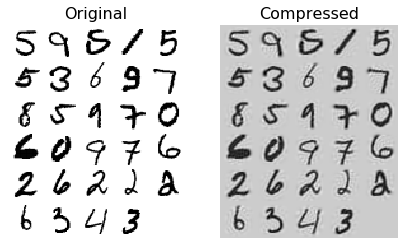

In [9]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


In [10]:
# %%time
rf_clf_reduced = RandomForestClassifier(n_estimators=200, random_state=42, max_samples=1000, max_features=20)
t0 = time.time()
rf_clf_reduced.fit(X_tr_reduced, y_train)
t1 = time.time()
print('Time used to train:',t1-t0,'seconds')

Time used to train: 5.015536308288574 seconds


In [11]:
y_hat_reduced = rf_clf_reduced.predict(X_te_reduced)
print(classification_report(y_test, y_hat_reduced))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1000
           1       0.92      0.97      0.94      1085
           2       0.88      0.87      0.88       989
           3       0.84      0.88      0.86      1006
           4       0.88      0.88      0.88      1001
           5       0.88      0.82      0.85       878
           6       0.91      0.94      0.92       963
           7       0.91      0.89      0.90      1110
           8       0.85      0.80      0.82       992
           9       0.85      0.83      0.84       976

    accuracy                           0.89     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.89      0.88     10000



`Summary`: PCA reduces the dimension of training set images from 784 to 154. However, it does not really boost up the speed of RandomForrestClassifier. RandomForrestClassifer, which based on DecisionTree, works on how to split the feature value and minimize the entropy. So if the feature number reduced significantly, it may actually give the algorithm a harder time to deal with splitting and take longer to run. Also, we could see for the test set, the accuracy is reduced after PCA.

Q. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

In [30]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

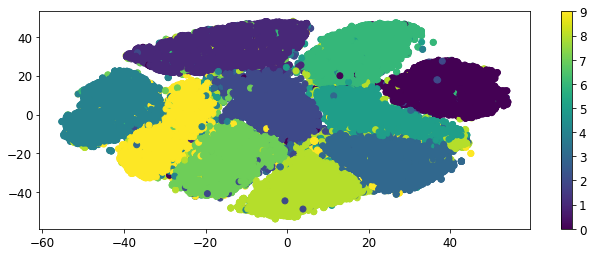

In [41]:
plt.figure(figsize=(11,4))
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1],c = y)
plt.colorbar()

##### I still keep this raw graph above for TSNE reduction here without touching it anymore, since it took so long to run for the full set. 

#####  Since this takes such a long time to calculate: will further use random amples out of 70000 for higher speed.

In [10]:
def random_sampling(m, random_state = 123):
    np.random.seed(random_state)
    idx = np.random.permutation(70000)[:m]
    
    X_sampled = mnist['data'][idx]
    y_sampled = mnist['target'][idx]
    return X_sampled, y_sampled


In [11]:
# Try MDS use 2000 samples

from sklearn.manifold import MDS
import time

X_sampled, y_sampled = random_sampling(2000) 

t0 = time.time()
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_sampled)
t1 = time.time()
print("time used:", t1-t0) 

time used: 103.81254887580872


In [12]:
# Try PCA, use more samples (5000)

X_sampled_more, y_sampled_more = random_sampling(5000)


t0 = time.time()
PCA2 = PCA(n_components=2, random_state=42)
X_reduced_PCA = PCA2.fit_transform(X_sampled_more)
t1 = time.time()
print("time used:", t1-t0) 

time used: 0.11852169036865234


In [13]:
# Try TSNE, use more sampless (5000)

from sklearn.manifold import TSNE

t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_sampled_more)
t1 = time.time()
print("time used:", t1-t0) 


time used: 51.93372392654419


In [14]:
# Try LLE, use more sampless (5000)

from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_sampled_more)
t1 = time.time()
print("time used:", t1-t0) 

time used: 35.910857915878296


#### Make for plots together

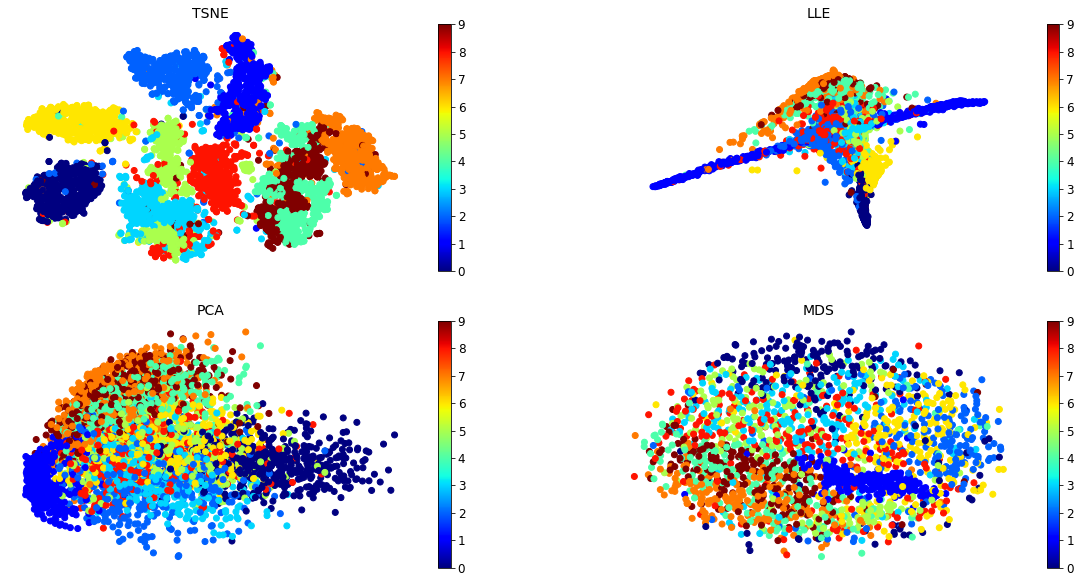

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1],c = y_sampled_more,cmap="jet")
plt.axis('off')
plt.title('TSNE', fontsize = 14)
plt.colorbar()
plt.subplot(2,2,2)
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1],c = y_sampled_more,cmap="jet")
plt.axis('off')
plt.title('LLE', fontsize = 14)
plt.colorbar()
plt.subplot(2,2,3)
plt.scatter(X_reduced_PCA[:, 0], X_reduced_PCA[:, 1],c = y_sampled_more,cmap="jet")
plt.axis('off')
plt.title('PCA', fontsize = 14)
plt.colorbar()
plt.subplot(2,2,4)
plt.scatter(X_reduced_mds[:, 0], X_reduced_mds[:, 1],c = y_sampled,cmap="jet")
plt.axis('off')
plt.title('MDS', fontsize = 14)
plt.colorbar()

In [16]:
## This part is taken from the class file
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(10, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[100., 100.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)


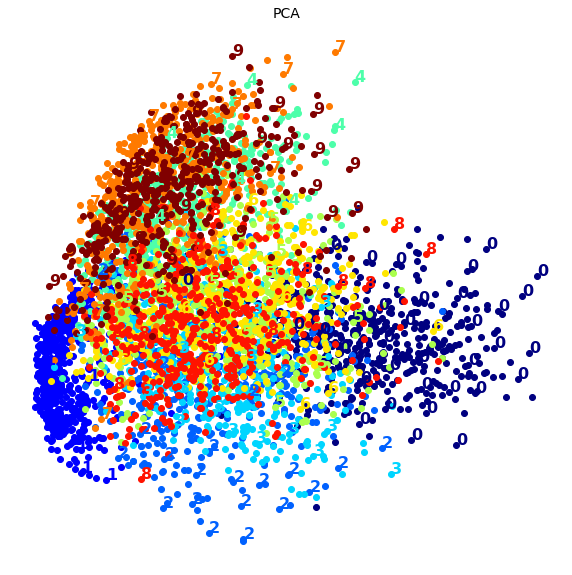

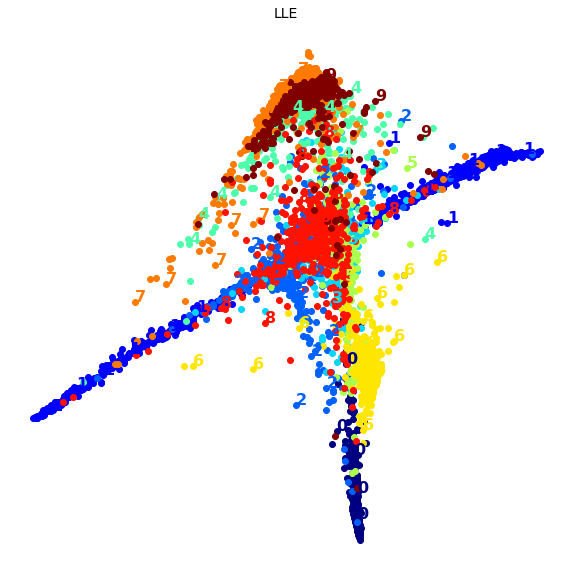

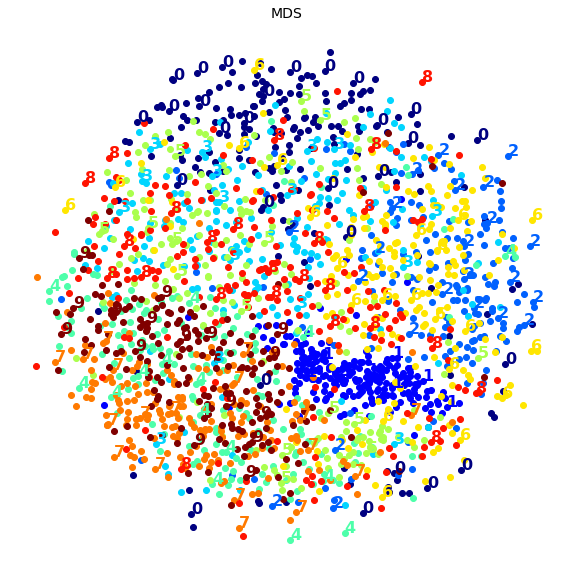

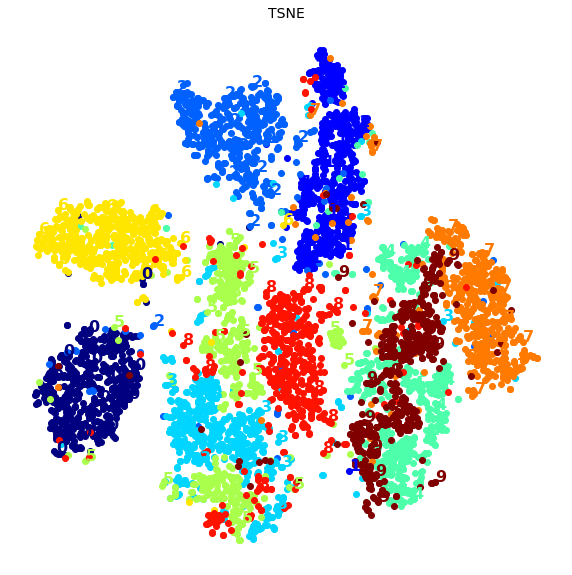

In [17]:
plot_digits(X_reduced_PCA, y_sampled_more)
plt.title("PCA",fontsize=14)

plot_digits(X_reduced_lle, y_sampled_more)
plt.title("LLE",fontsize=14)

plot_digits(X_reduced_mds, y_sampled)
plt.title("MDS",fontsize=14)

plot_digits(X_reduced_tsne, y_sampled_more)
plt.title("TSNE",fontsize=14)

plt.show()


- As seen from the images: the TSNE algorithm wokrs the best. From the TSNE graph, we could even see that it is hard to distinguish 9 vs. 4, 8 vs. 5, and 5 vs. 3
- In terms of calculation speed: PCA > LLE > TSNE > MDS (from fastest to the slowest)


### Submit your notebook

Submit your solution here

Make sure you rename your notebook to    
W3_UTORid.ipynb    
Example W3_adfasd01.ipynb
